# Parameter Sensitivity Study

In this section, we show how we performed our parameter sensitivity study
given in the supplementary material of the paper. For this study,
we use the problem for Case Study 3 in the case that the continuum limit
is inaccurate. We set up this problem
below.

In [1]:
using StepwiseEQL
using CairoMakie
using EpithelialDynamics1D
using OrdinaryDiffEq
using Random
using Setfield
final_time = 75.0
domain_length = 30.0
midpoint = domain_length / 2
initial_condition = [LinRange(0, 5, 30); LinRange(25, 30, 30)] |> unique!
damping_constant = 1.0
resting_spring_length = 0.2
spring_constant = 1 / 5
k = spring_constant
force_law_parameters = (s=resting_spring_length, k=spring_constant)
force_law = (δ, p) -> p.k * (p.s - δ)
Δt = 1e-2
K = 15.0
β = 0.15
G = (δ, p) -> p.β * (one(δ) - inv(p.K * δ))
Gp = (β=β, K=K)
prob = CellProblem(;
    final_time,
    initial_condition,
    damping_constant,
    force_law,
    force_law_parameters,
    proliferation_law=G,
    proliferation_period=Δt,
    proliferation_law_parameters=Gp)

CellProblem{Main.var"##17041".var"#1#2", NamedTuple{(:s, :k), Tuple{Float64, Float64}}, Main.var"##17041".var"#3#4", NamedTuple{(:β, :K), Tuple{Float64, Float64}}}(Main.var"##17041".var"#1#2"(), (s = 0.2, k = 0.2), Main.var"##17041".var"#3#4"(), (β = 0.15, K = 15.0), 0.01, 0.0, 75.0, true, true, 1.0, [0.0, 0.1724137931034483, 0.3448275862068966, 0.5172413793103449, 0.6896551724137931, 0.8620689655172414, 1.0344827586206897, 1.206896551724138, 1.3793103448275863, 1.5517241379310345  …  28.448275862068964, 28.620689655172413, 28.79310344827586, 28.965517241379313, 29.137931034482758, 29.310344827586206, 29.482758620689655, 29.655172413793103, 29.827586206896555, 30.0])

The following function will be used for solving `ens_prob`.

In [2]:
function solve_problem(prob; saveat=0.1, trajectories=1000, final_time=75.0)
    prob = @set prob.final_time = final_time
    ens_prob = EnsembleProblem(prob)
    return solve(ens_prob, Tsit5(), EnsembleThreads(); saveat, trajectories) # multithreading ⟹ not deterministic
end;

The function below solves the equation learning problem and also returns the loss. We also extract
the learned vectors.

In [3]:
const diffusion_basis = PolynomialBasis(-1, -3)
const reaction_basis = PolynomialBasis(1, 5)
function solve_eql_problem(esol::EnsembleSolution; num_knots=200, τq=0.25)
    eql_sol = stepwise_selection(esol; diffusion_basis, reaction_basis,
        threshold_tol=(q=τq,), num_knots=num_knots, initial=:none, show_progress=true, max_steps=10)
    return eql_sol, eql_sol.loss_history[end], eql_sol.diffusion_theta, eql_sol.reaction_theta
end;

Now that we have our functions, we need to solve the problem
for a large combination of parameters. We could do an extremely large
combination, taking into account all the parameters, but this leads to a
combinatorial issue. Instead, we vary parameters one at a time,
using as default the values that led to a good result in the paper.
The following ranges are what we use.

In [4]:
base_saveat = 0.1
base_trajectories = 1000
base_num_knots = 200
base_τq = 0.25
base_final_time = 75.0
n = 25
saveat = LinRange(0.1, 1.0, n)
trajectories = round.(Int, LinRange(10, 1000, n))
final_time = LinRange(1.0, 100.0, n)
num_knots = round.(Int, LinRange(10, 250, n))
τq = LinRange(0, 0.49, n)

25-element LinRange{Float64, Int64}:
 0.0, 0.0204167, 0.0408333, 0.06125, …, 0.42875, 0.449167, 0.469583, 0.49

Now we define the function that performs the study.

In [5]:
function perform_study(saveat, trajectories, final_time, num_knots, τq,
    base_saveat, base_trajectories, base_final_time, base_num_knots, base_τq)
    n = length(saveat)
    @assert n == length(trajectories) == length(final_time) == length(num_knots) == length(τq)
    loss = zeros(n, 5)
    diffusion_theta = Matrix{Vector{Float64}}(undef, n, 5)
    reaction_theta = Matrix{Vector{Float64}}(undef, n, 5)
    base_esol = solve_problem(prob; saveat=base_saveat, trajectories=base_trajectories, final_time=base_final_time)
    for i in axes(loss, 1) # 1:n
        @info "Starting loop $i: Solving esol_saveat"
        esol_saveat = solve_problem(prob; saveat=saveat[i], trajectories=base_trajectories, final_time=base_final_time)
        @info "Starting loop $i: Solving esol_trajectories"
        esol_trajectories = solve_problem(prob; saveat=base_saveat, trajectories=trajectories[i], final_time=base_final_time)
        @info "Starting loop $i: Solving esol_final_time"
        esol_final_time = solve_problem(prob; saveat=base_saveat, trajectories=base_trajectories, final_time=final_time[i])
        @info "Starting loop $i: Solving eql_sol_saveat"
        eql_sol_saveat = solve_eql_problem(esol_saveat; num_knots=base_num_knots, τq=base_τq)
        @info "Starting loop $i: Solving eql_sol_trajectories"
        eql_sol_trajectories = solve_eql_problem(esol_trajectories; num_knots=base_num_knots, τq=base_τq)
        @info "Starting loop $i: Solving eql_sol_final_time"
        eql_sol_final_time = solve_eql_problem(esol_final_time; num_knots=base_num_knots, τq=base_τq)
        @info "Starting loop $i: Solving eql_sol_num_knots"
        eql_sol_num_knots = solve_eql_problem(base_esol; num_knots=num_knots[i], τq=base_τq)
        @info "Starting loop $i: Solving eql_sol_τq"
        eql_sol_τq = solve_eql_problem(base_esol; num_knots=base_num_knots, τq=τq[i])
        loss[i, 1], diffusion_theta[i, 1], reaction_theta[i, 1] = eql_sol_saveat[2], eql_sol_saveat[3], eql_sol_saveat[4]
        loss[i, 2], diffusion_theta[i, 2], reaction_theta[i, 2] = eql_sol_trajectories[2], eql_sol_trajectories[3], eql_sol_trajectories[4]
        loss[i, 3], diffusion_theta[i, 3], reaction_theta[i, 3] = eql_sol_final_time[2], eql_sol_final_time[3], eql_sol_final_time[4]
        loss[i, 4], diffusion_theta[i, 4], reaction_theta[i, 4] = eql_sol_num_knots[2], eql_sol_num_knots[3], eql_sol_num_knots[4]
        loss[i, 5], diffusion_theta[i, 5], reaction_theta[i, 5] = eql_sol_τq[2], eql_sol_τq[3], eql_sol_τq[4]
        GC.gc(true)
    end
    return loss, diffusion_theta, reaction_theta
end;

Finally, we perform the actual study. For the interest of time, we have already saved the results below,
but if you like you can delete that file so that `perform_study` runs.

In [6]:
using JLD2
file = joinpath(@__DIR__, "study_data.jld2")
if isfile(file)
    loss, diffusion_theta, reaction_theta = load(file, "loss", "diffusion_theta", "reaction_theta")
else
    loss, diffusion_theta, reaction_theta = perform_study(saveat, trajectories, final_time, num_knots, τq,
        base_saveat, base_trajectories, base_final_time, base_num_knots, base_τq)
    jldsave(file; loss, diffusion_theta, reaction_theta)
end
loss

25×5 Matrix{Float64}:
 -1.41202    0.218977   -1.28605     0.0485026   0.157787
 -1.48509    0.223239   -0.542106    0.145979    0.150478
 -1.50792    0.171062   -0.294267   -2.33106     0.148175
 -1.58726    0.499913   -0.116057    0.171795    0.146162
 -1.37637   -0.665585    0.0777995  -1.52556     0.146085
 -1.44503   -0.189348    0.283773   -1.37348     0.146531
 -1.58663    0.0343827   0.421261   -1.47228    -0.428542
 -1.13271    0.0573022   0.473797   -1.19045    -0.890627
 -1.52602    0.154333    0.4992     -1.36483    -1.93552
 -1.4042     0.163611    0.497109   -1.6264     -1.99353
  ⋮                                             
 -1.22387   -0.808567   -1.74277    -1.80204     0.280287
 -1.48064   -0.256367   -1.41314    -1.37718    -0.151857
 -0.789996  -1.2197     -1.41461    -1.5161     -0.572297
 -0.81866   -0.899402   -0.674076   -1.45685     0.343656
 -1.49702   -1.47391    -0.353403   -1.314       0.331141
 -0.801099  -0.869353    0.104088   -1.21078     0.381131
 -1

Let us now visualise the results.

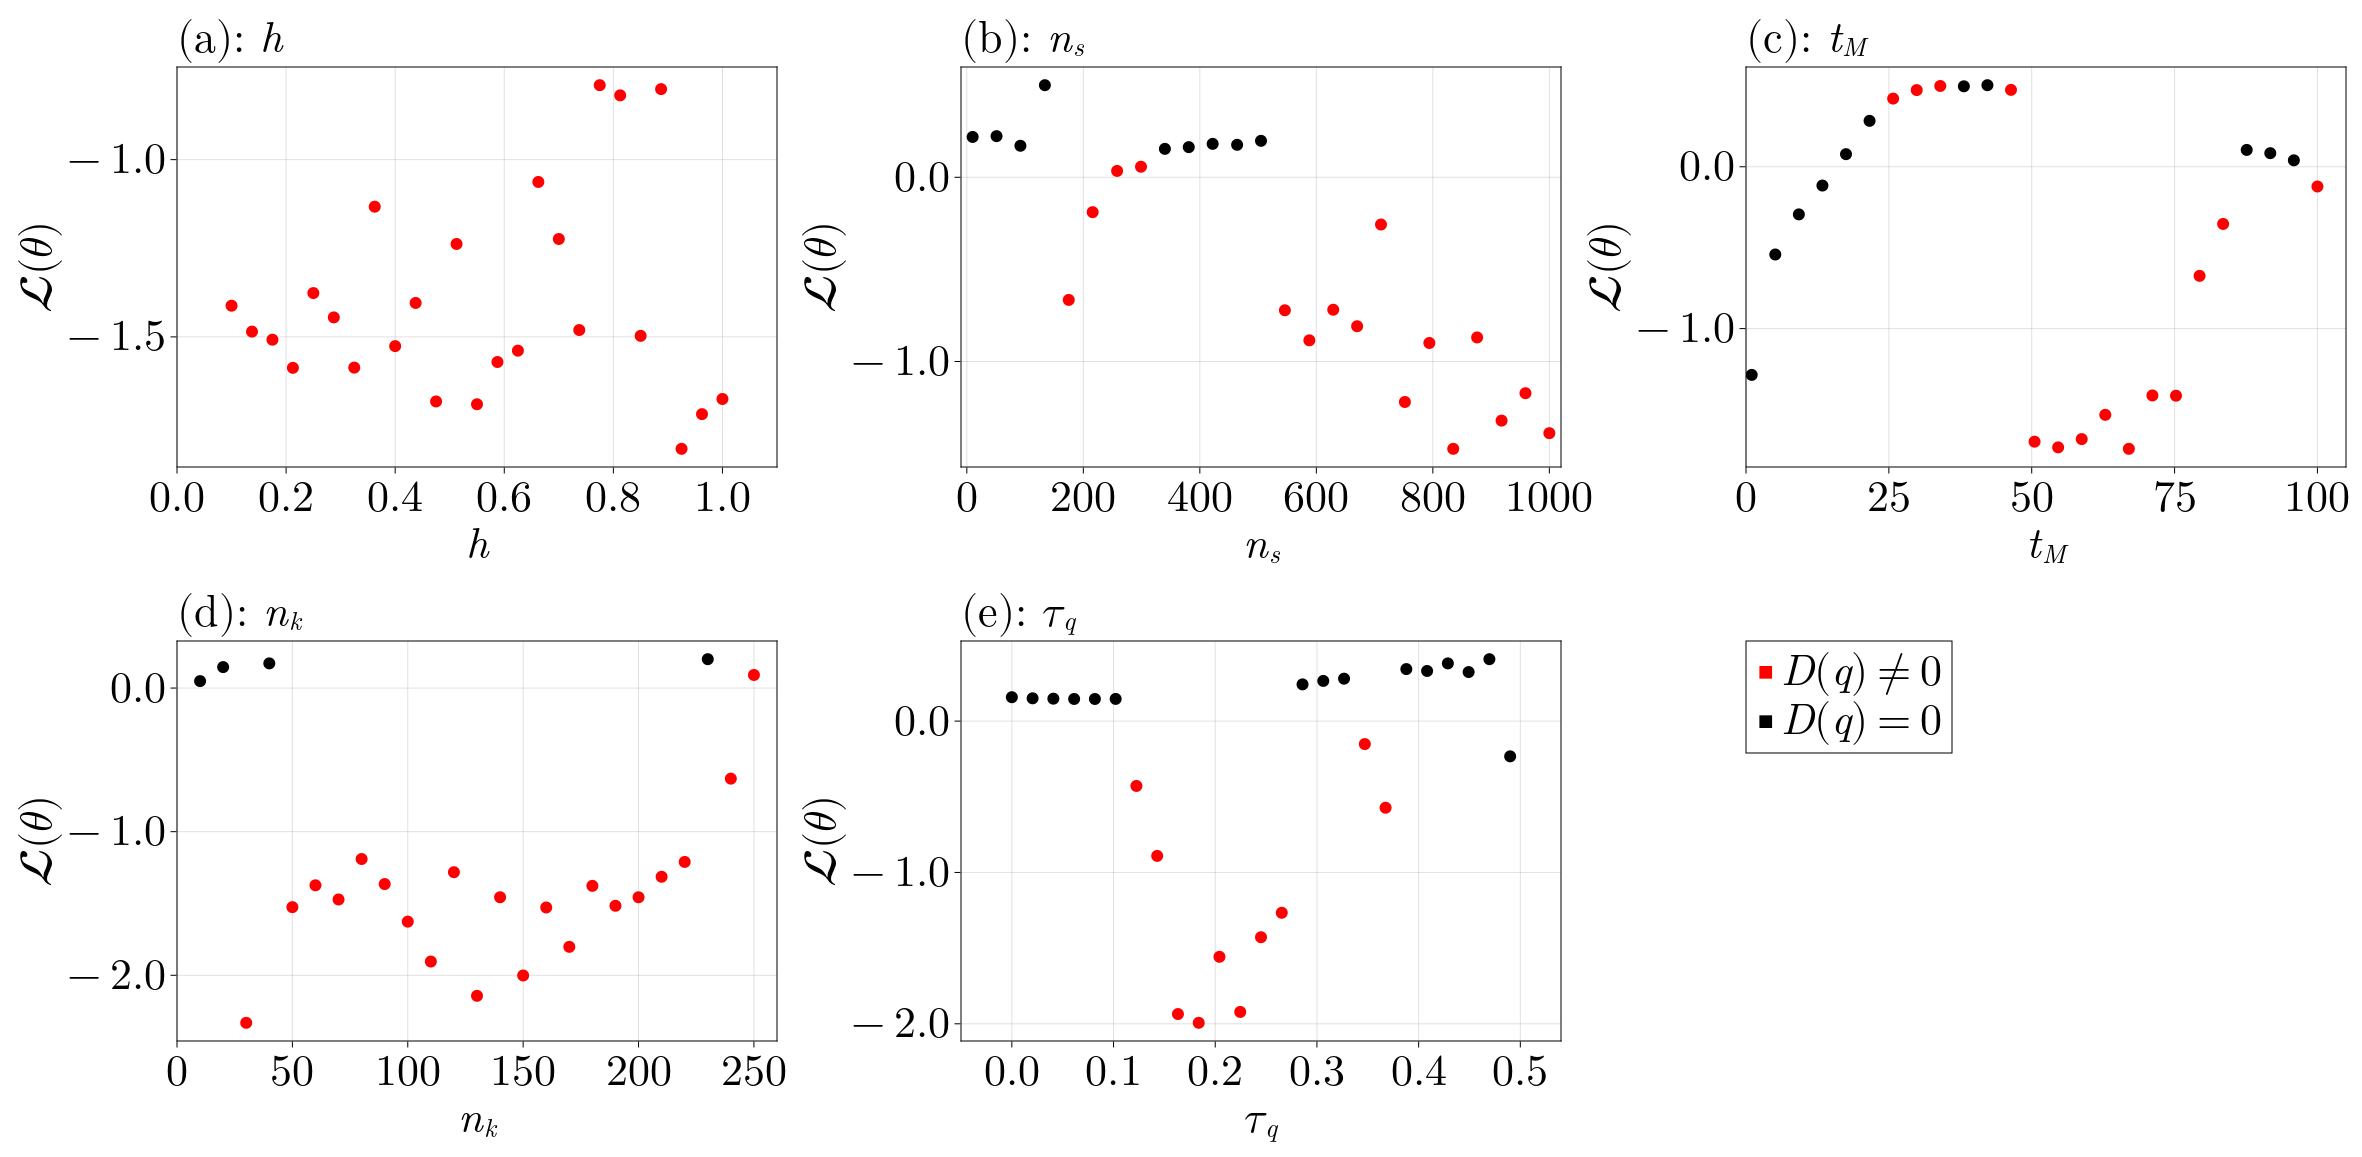

In [7]:
saveat_loss, trajectories_loss, final_time_loss, num_knots_loss, τq_loss = eachcol(loss)
diffθ_iszero = all.(iszero, diffusion_theta)
saveat_zerodiffθ, trajectories_zerodiffθ, final_time_zerodiffθ, num_knots_zerodiffθ, τq_zerodiffθ = eachcol(diffθ_iszero)
fig = Figure(fontsize=44)
ax1 = Axis(fig[1, 1], xlabel=L"h", ylabel=L"\mathcal{L}(\mathbf{\theta})",
    title=L"(a): $h$", titlealign=:left, width=600, height=400,
    xticks=(0:0.2:1, [L"%$s" for s in 0:0.2:1]),
    yticks=(-1.5:0.5:0.5, [L"%$s" for s in -1.5:0.5:0.5]))
ax2 = Axis(fig[1, 2], xlabel=L"n_s", ylabel=L"\mathcal{L}(\mathbf{\theta})",
    title=L"(b): $n_s$", titlealign=:left, width=600, height=400,
    xticks=(0:200:1000, [L"%$s" for s in 0:200:1000]),
    yticks=(-2:0.5, [L"%$s" for s in -2:0.5]))
ax3 = Axis(fig[1, 3], xlabel=L"t_M", ylabel=L"\mathcal{L}(\mathbf{\theta})",
    title=L"(c): $t_M$", titlealign=:left, width=600, height=400,
    xticks=(0:25:100, [L"%$s" for s in 0:25:100]),
    yticks=(-2:0.5, [L"%$s" for s in -2:0.5]))
ax4 = Axis(fig[2, 1], xlabel=L"n_k", ylabel=L"\mathcal{L}(\mathbf{\theta})",
    title=L"(d): $n_k$", titlealign=:left, width=600, height=400,
    xticks=(0:50:250, [L"%$s" for s in 0:50:250]),
    yticks=(-2:0.5, [L"%$s" for s in -2:0.5]))
ax5 = Axis(fig[2, 2], xlabel=L"\tau_q", ylabel=L"\mathcal{L}(\mathbf{\theta})",
    title=L"(e): $\tau_q$", titlealign=:left, width=600, height=400,
    xticks=(0:0.1:0.5, [L"%$s" for s in 0:0.1:0.5]),
    yticks=(-2:0.5, [L"%$s" for s in -2:0.5]))
scatter!(ax1, saveat, saveat_loss, markersize=17, color=[iszero(d) ? :red : :black for d in saveat_zerodiffθ])
scatter!(ax2, trajectories, trajectories_loss, markersize=17, color=[iszero(d) ? :red : :black for d in trajectories_zerodiffθ])
scatter!(ax3, final_time, final_time_loss, markersize=17, color=[iszero(d) ? :red : :black for d in final_time_zerodiffθ])
scatter!(ax4, num_knots, num_knots_loss, markersize=17, color=[iszero(d) ? :red : :black for d in num_knots_zerodiffθ])
scatter!(ax5, τq, τq_loss, markersize=17, color=[iszero(d) ? :red : :black for d in τq_zerodiffθ])
xlims!(ax1, 0, 0.1 + maximum(saveat))
xlims!(ax2, [-20, 20] .+ extrema(trajectories)...)
xlims!(ax3, [-1, 5] .+ extrema(final_time)...)
xlims!(ax4, [-10, 10] .+ extrema(num_knots)...)
xlims!(ax5, [-0.05, 0.05] .+ extrema(τq)...)
Legend(fig[2, 3],
    [MarkerElement(color=:red, marker='.', markersize=122),
        MarkerElement(color=:black, marker='.', markersize=122)],
    [L"D(q) \neq 0", L"D(q) = 0"],
    halign=:left, valign=:top)
resize_to_layout!(fig)
fig

We colour the points in the above figure according to whether the learned
$D(q)$ is zero. We see little sensitivity to the number of time points.
The number of simulations, $n_s$, also does not seem to matter so much, so long as there is
a sufficient number of them. The final time, $t_M$, seems to be
impactful, with only the interval $50 \leq t_m \leq 75$ giving
reasonable results. The number of knots used for averaging, $n_k$,
does not matter as much, so long as there are not too few. Lastly,
$\tau_q$ seems to be the most important parameter, with reasonable
results only obtained for $\tau_q \approx 0.25$.

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*